In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense


#evaluation metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

#other libraries
import math
from collections import Counter

In [2]:
import warnings
warnings.filterwarnings('ignore')

****Load Data & EDA & Preprocessing****

**1. Load Data**

In [3]:
df = pd.read_csv("Data/Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**2. Data Info**

In [4]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


**3. Kiểm tra N/A - Duplicated - outliers**

*3.1. N/A*

In [6]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

*3.2. Duplicated*

In [7]:
df.duplicated().sum()

0

*3.3. Outlier*

In [8]:
def detect_outliers_iqr(df):
    outliers = pd.DataFrame(columns=['Feature', 'Outlier Count'])
    for column in df.select_dtypes(include=['float64', 'int64']):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_count = df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0]
        outliers = pd.concat([outliers, pd.DataFrame({'Feature': [column], 'Outlier Count': [outlier_count]})], ignore_index=True)
    return outliers

outliers = detect_outliers_iqr(df)
print(outliers)


            Feature Outlier Count
0         RowNumber             0
1        CustomerId             0
2       CreditScore            15
3               Age           359
4            Tenure             0
5           Balance             0
6     NumOfProducts            60
7         HasCrCard             0
8    IsActiveMember             0
9   EstimatedSalary             0
10           Exited          2037


Features with outliers:
CreditScore: 0.15%
Age: 3.59%
NumOfProducts: 0.60%
Exited: 20.37%


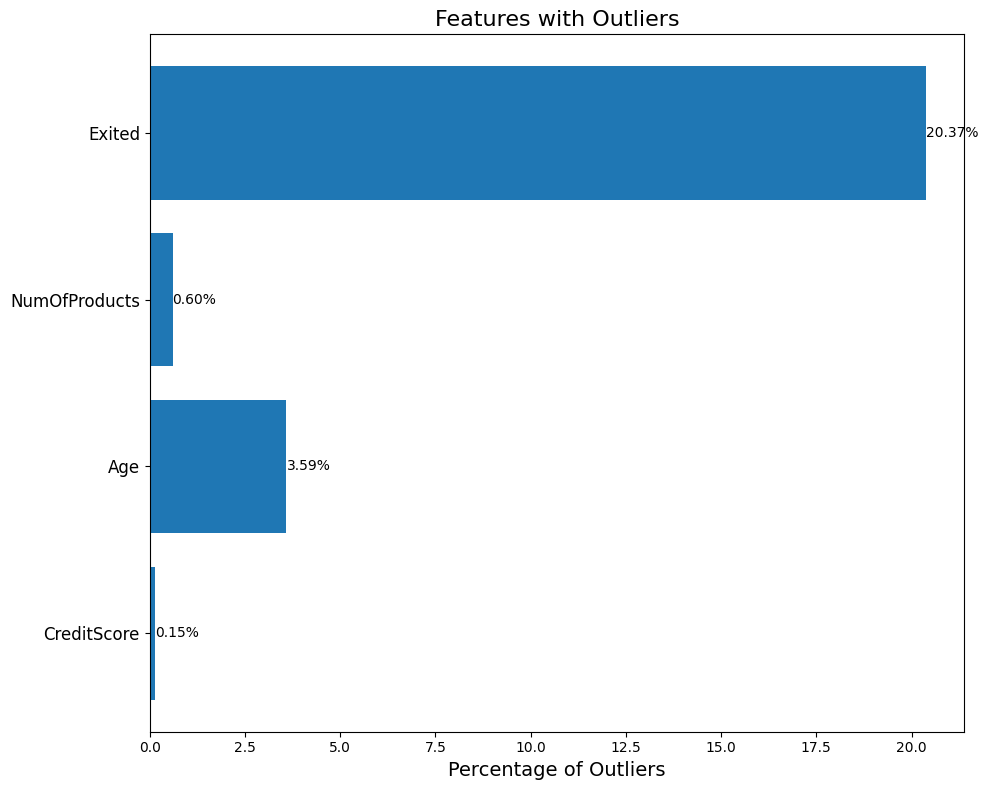

In [9]:
# Định nghĩa hàm numerical_features
def numerical_features(df):
    return df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Định nghĩa hàm identify_outliers
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Lấy danh sách các cột số
numerical_features = numerical_features(df)

# Tính toán tỷ lệ giá trị ngoại lệ cho từng cột
outliers_info = {}
for feature in numerical_features:
    outliers = identify_outliers(df, feature)
    outlier_percentage = (len(outliers) / len(df)) * 100
    if outlier_percentage > 0:
        outliers_info[feature] = outlier_percentage

# Hiển thị các cột có tỷ lệ giá trị ngoại lệ lớn hơn 1%
print("Features with outliers:")
for feature, percentage in outliers_info.items():
    print(f"{feature}: {percentage:.2f}%")

# Trực quan hóa các cột có tỷ lệ giá trị ngoại lệ cao
features = list(outliers_info.keys())
percentages = list(outliers_info.values())

fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(features, percentages)

# Thêm nhãn dữ liệu
for bar in bars:
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}%', va='center')

# Đặt nhãn và tiêu đề
ax.set_xlabel('Percentage of Outliers', fontsize=14)
ax.set_title('Features with Outliers', fontsize=16)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

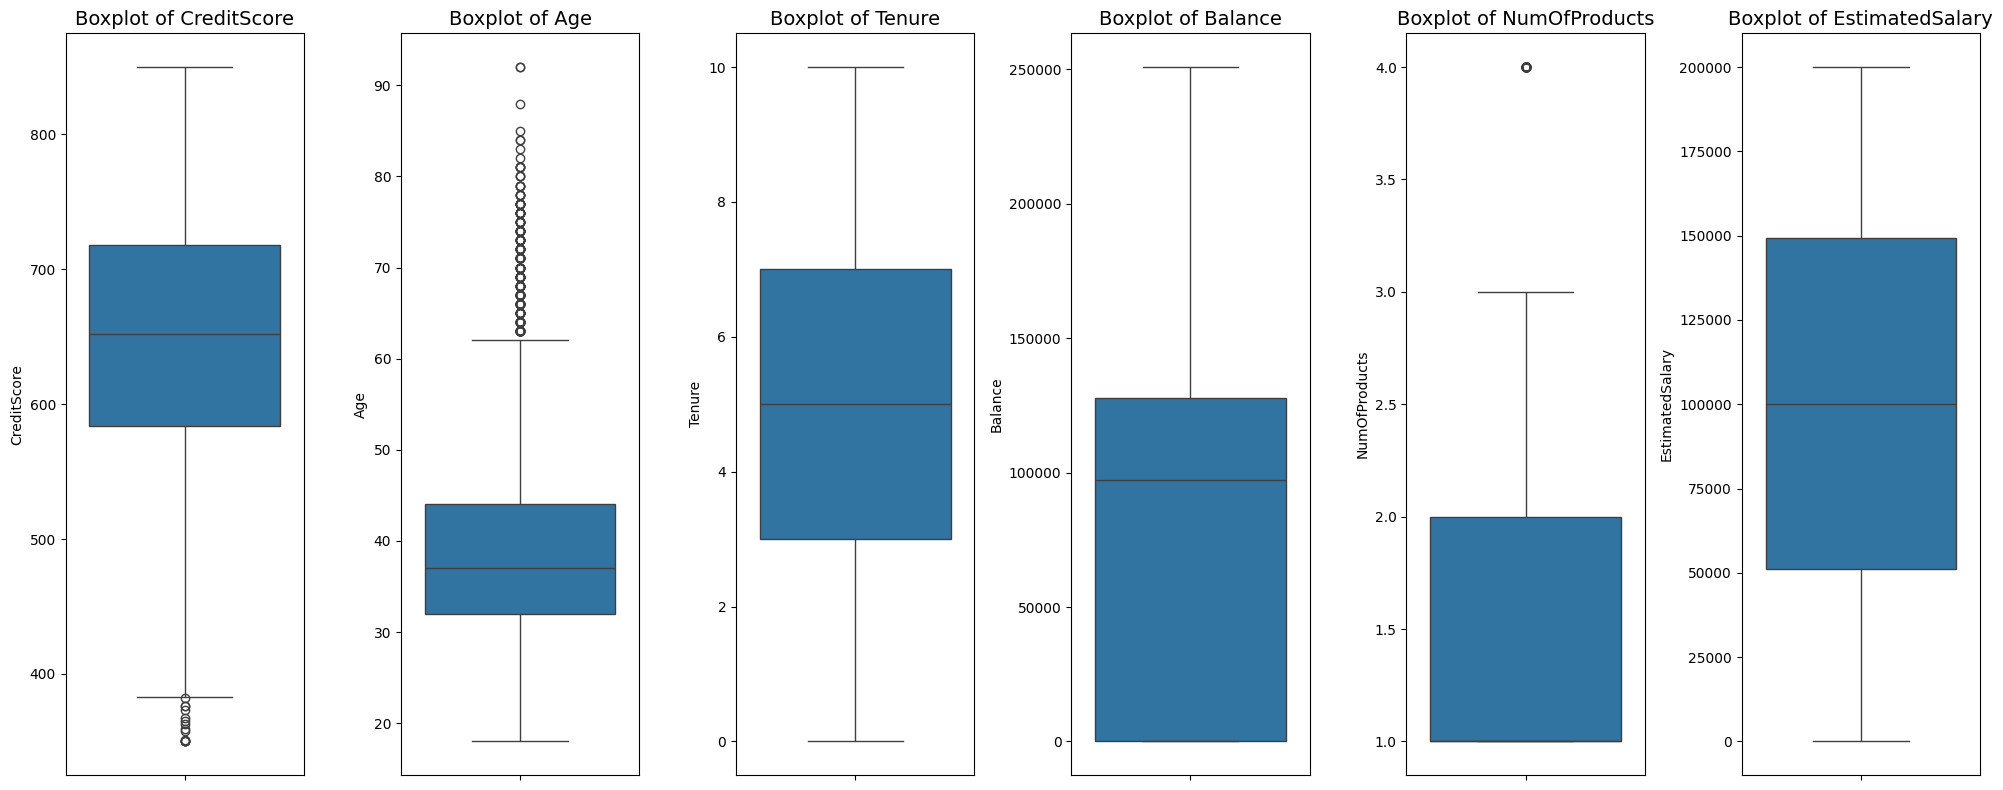

In [10]:
def detect_outliers_iqr(df):
    outliers = pd.DataFrame(columns=['Feature', 'Outliers'])
    for column in df.select_dtypes(include=['float64', 'int64']):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_data = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers = pd.concat([outliers, pd.DataFrame({'Feature': [column], 'Outliers': [outlier_data]})], ignore_index=True)
    return outliers

features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
df_selected_features = df[features]
outliers_detected = detect_outliers_iqr(df_selected_features)


plt.figure(figsize=(20, 8))
for i, column in enumerate(features, 1):
    plt.subplot(1,6, i)
    sns.boxplot(df[column])
    plt.title(f'Boxplot of {column}', fontsize = 14)
plt.tight_layout()
plt.show()

**4. Phân tích phân phối của các biến số**

*4.1. Phân phối giữa các biến số thực, số nguyên*

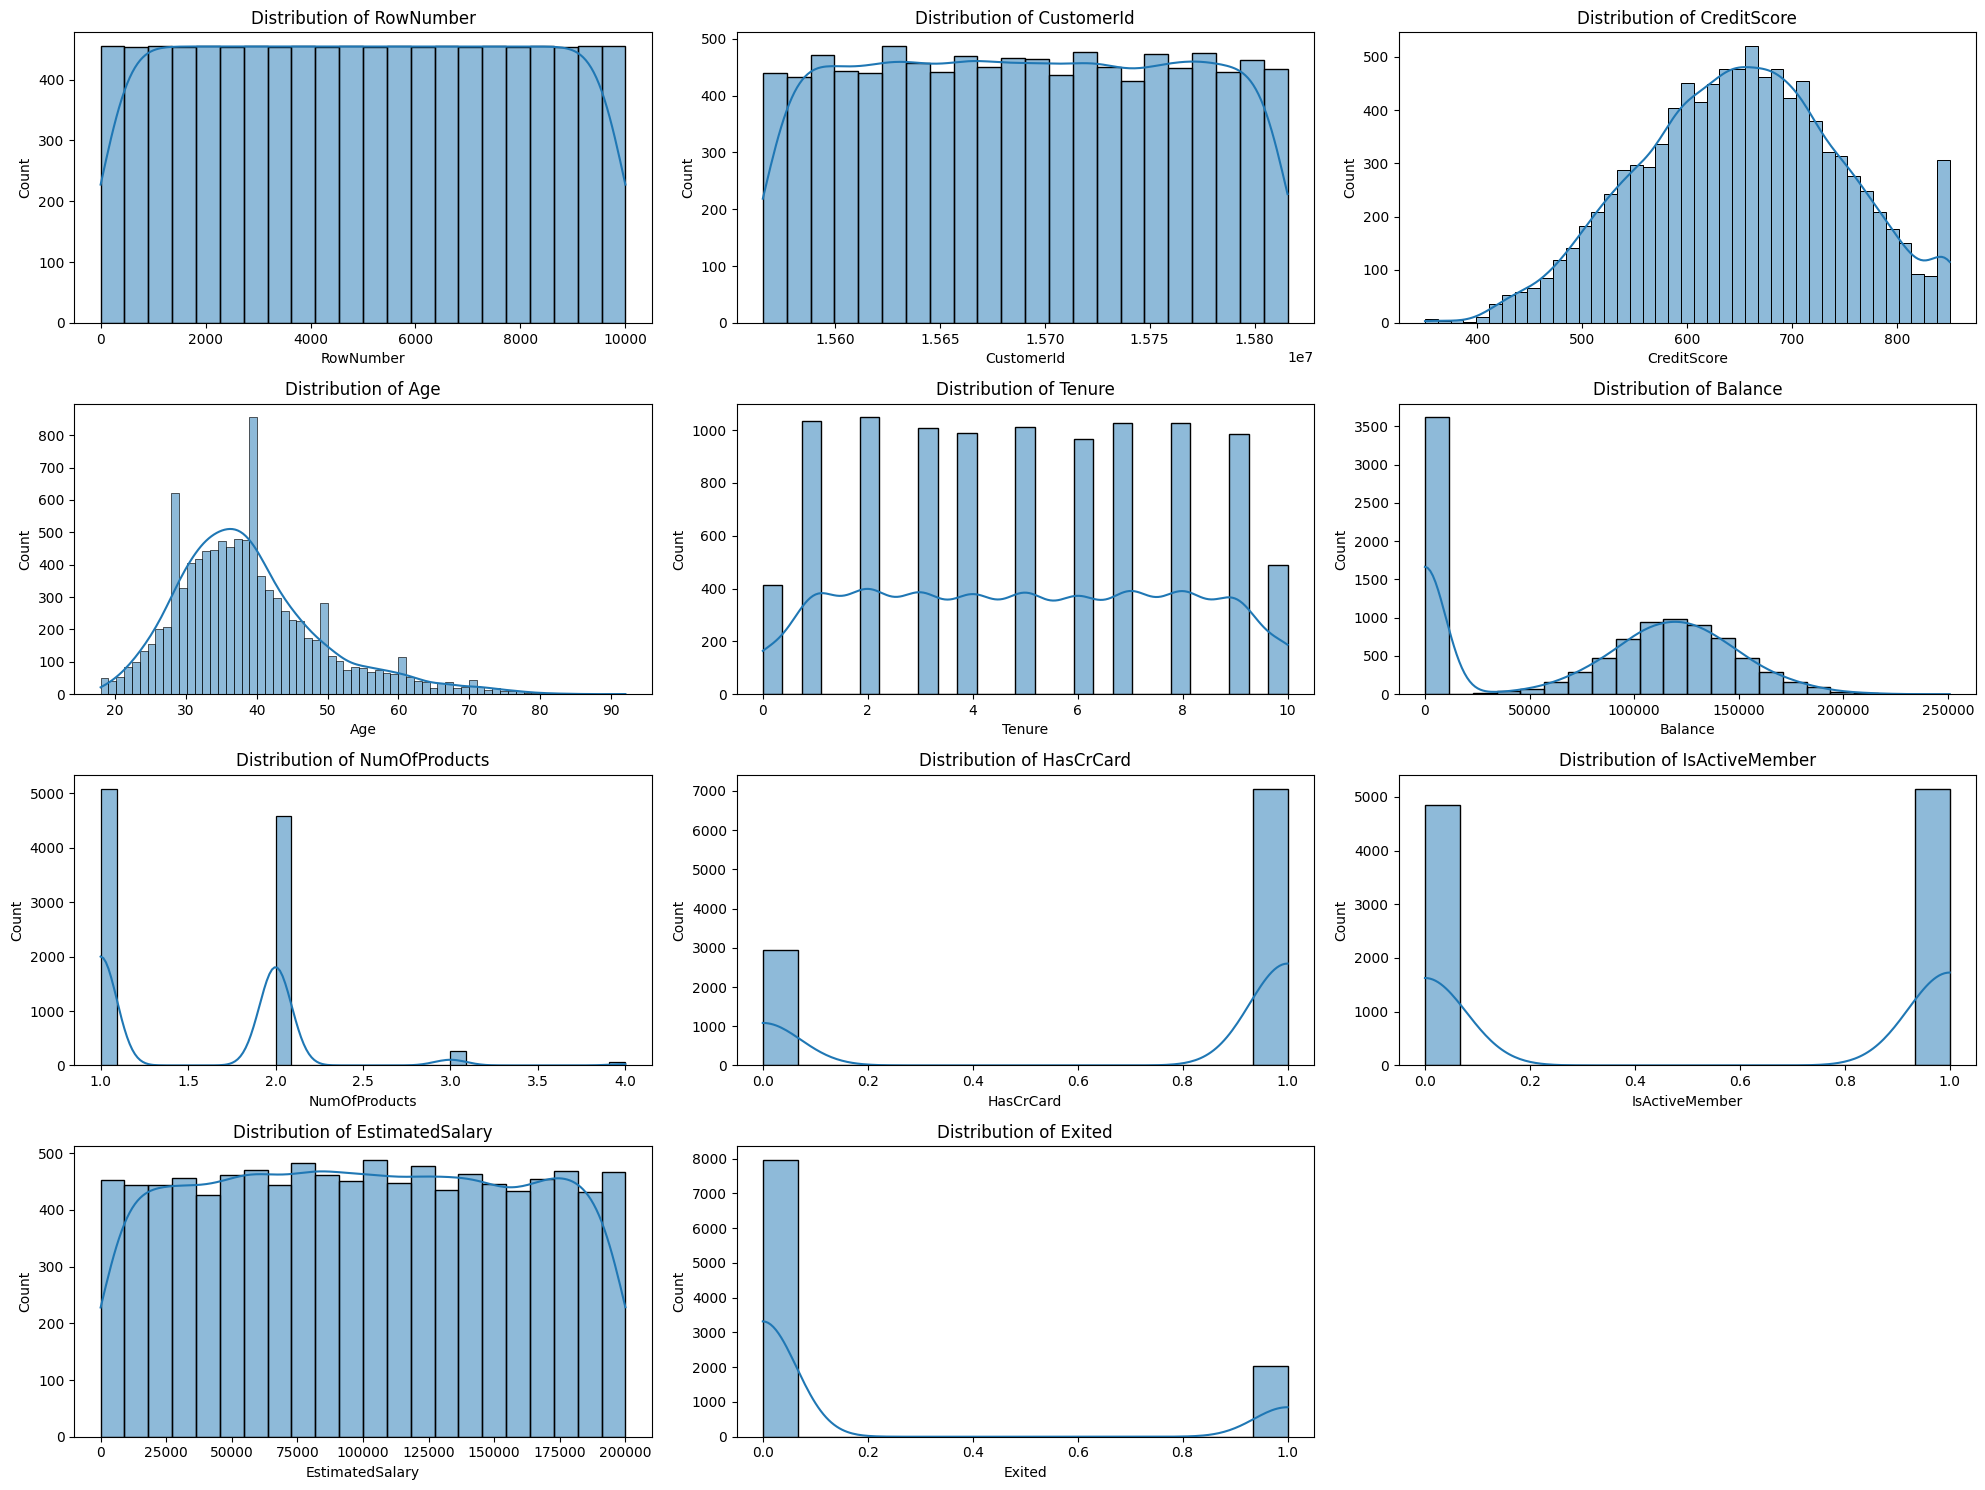

In [11]:
plt.figure(figsize=(20, 15))
for i, column in enumerate(df.select_dtypes(include=['float64', 'int64']).columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()


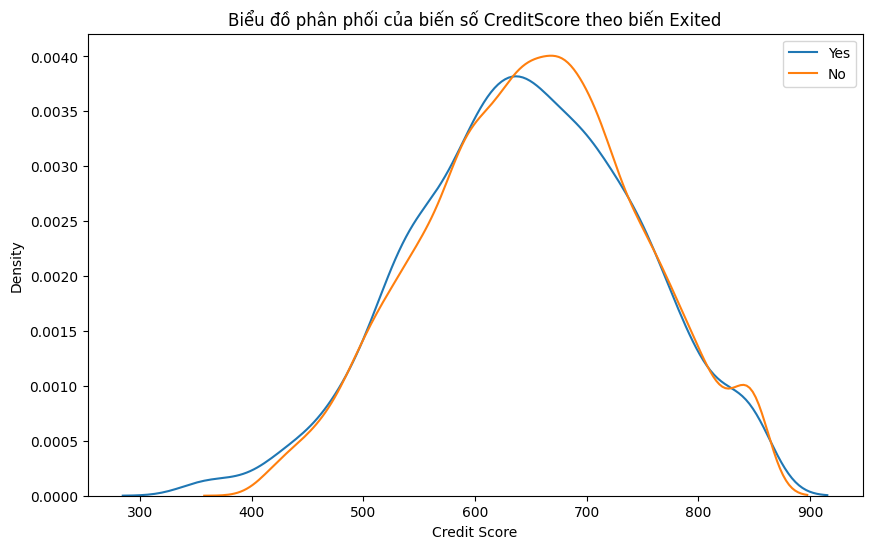

In [12]:
plt.figure(figsize=(10, 6))
sns.distplot(df.loc[df["Exited"]==1, "CreditScore"], hist=False, label = "Yes")
sns.distplot(df.loc[df["Exited"]==0, "CreditScore"], hist=False, label = "No")
plt.xlabel('Credit Score')
plt.ylabel('Density')
plt.title("Biểu đồ phân phối của biến số CreditScore theo biến Exited"); plt.legend()
plt.legend()
plt.show()

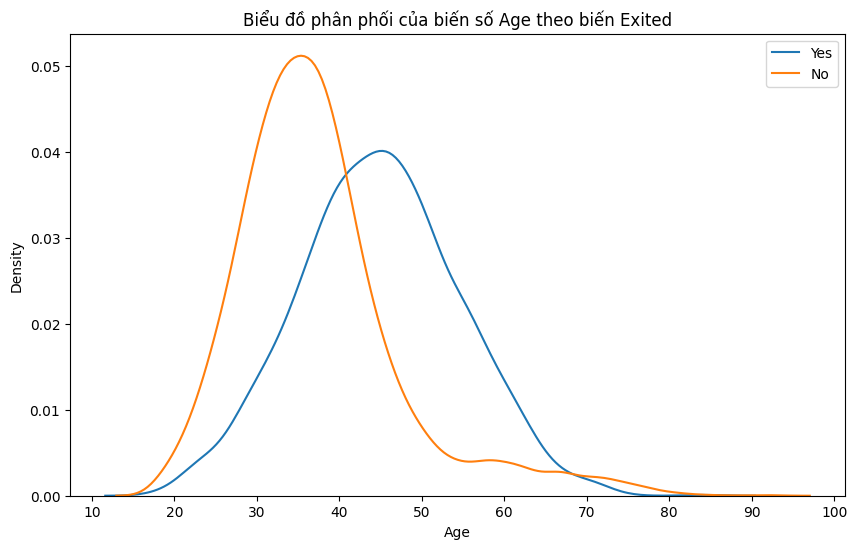

In [13]:
plt.figure(figsize=(10, 6))
sns.distplot(df.loc[df["Exited"]==1, "Age"], hist=False, label = "Yes")
sns.distplot(df.loc[df["Exited"]==0, "Age"], hist=False, label = "No")
plt.xlabel('Age')
plt.ylabel('Density')
plt.title("Biểu đồ phân phối của biến số Age theo biến Exited"); 
plt.xticks(ticks=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.legend()
plt.show()

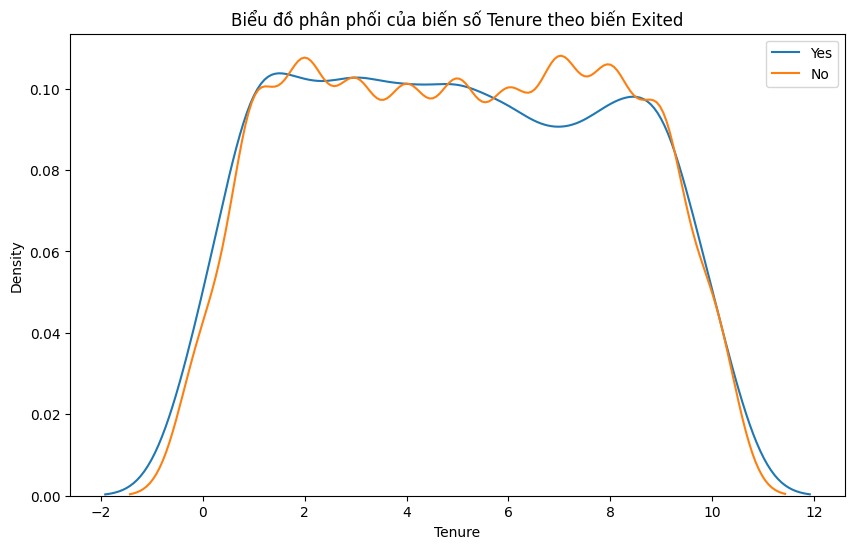

In [14]:
plt.figure(figsize=(10, 6))
sns.distplot(df.loc[df["Exited"]==1, "Tenure"], hist=False, label = "Yes")
sns.distplot(df.loc[df["Exited"]==0, "Tenure"], hist=False, label = "No")
plt.xlabel('Tenure')
plt.ylabel('Density')
plt.title("Biểu đồ phân phối của biến số Tenure theo biến Exited"); plt.legend()
plt.legend()
plt.show()

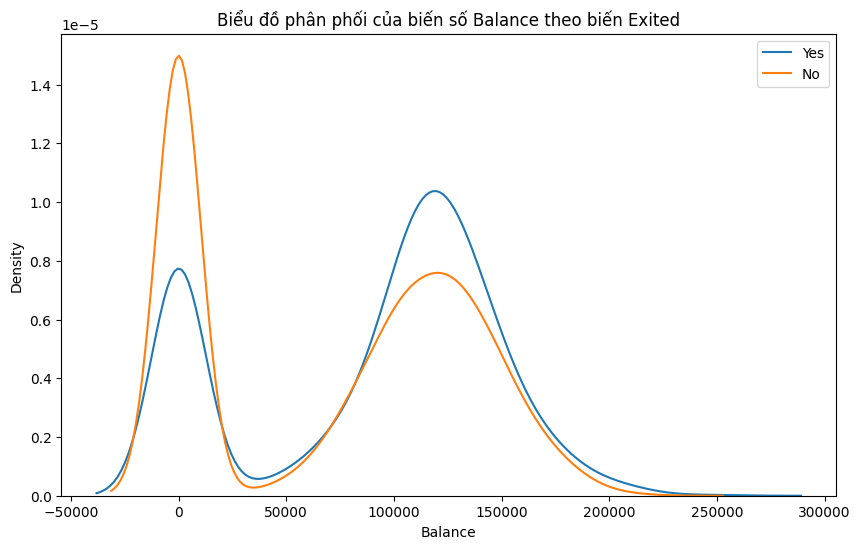

In [15]:
plt.figure(figsize=(10, 6))
sns.distplot(df.loc[df["Exited"]==1, "Balance"], hist=False, label = "Yes")
sns.distplot(df.loc[df["Exited"]==0, "Balance"], hist=False, label = "No")
plt.xlabel('Balance')
plt.ylabel('Density')
plt.title("Biểu đồ phân phối của biến số Balance theo biến Exited"); plt.legend()
plt.legend()
plt.show()

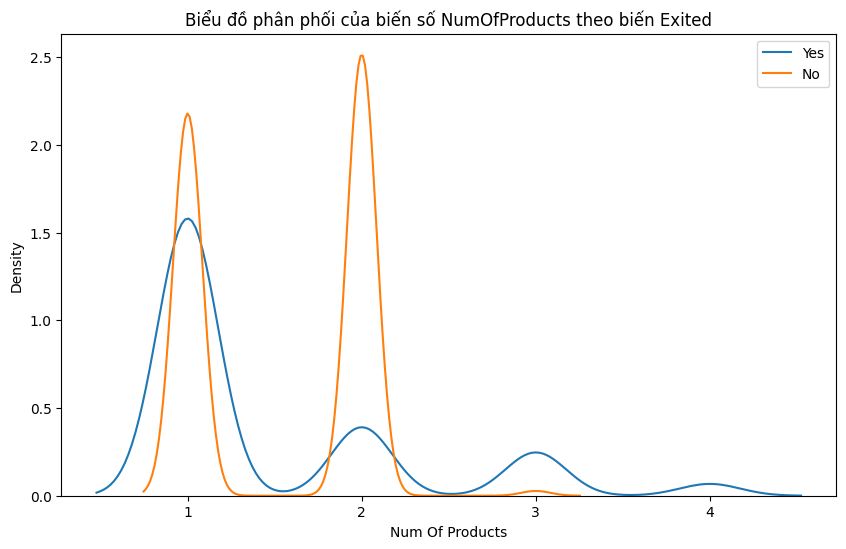

In [16]:
plt.figure(figsize=(10, 6))
sns.distplot(df.loc[df["Exited"]==1, "NumOfProducts"], hist=False, label = "Yes")
sns.distplot(df.loc[df["Exited"]==0, "NumOfProducts"], hist=False, label = "No")
plt.xlabel('Num Of Products')
plt.ylabel('Density')
plt.title("Biểu đồ phân phối của biến số NumOfProducts theo biến Exited");
plt.xticks(ticks=[1, 2, 3, 4])
plt.legend()
plt.show()

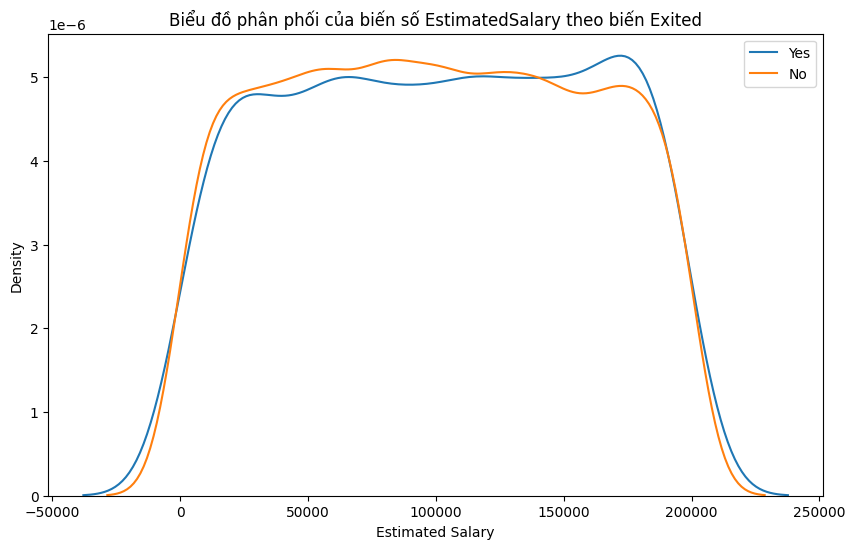

In [17]:
plt.figure(figsize=(10, 6))
sns.distplot(df.loc[df["Exited"]==1, "EstimatedSalary"], hist=False, label = "Yes")
sns.distplot(df.loc[df["Exited"]==0, "EstimatedSalary"], hist=False, label = "No")
plt.xlabel('Estimated Salary')
plt.ylabel('Density')
plt.title("Biểu đồ phân phối của biến số EstimatedSalary theo biến Exited")
plt.legend()
plt.show()

*4.2. Phân phối giữa các biến phân loại*

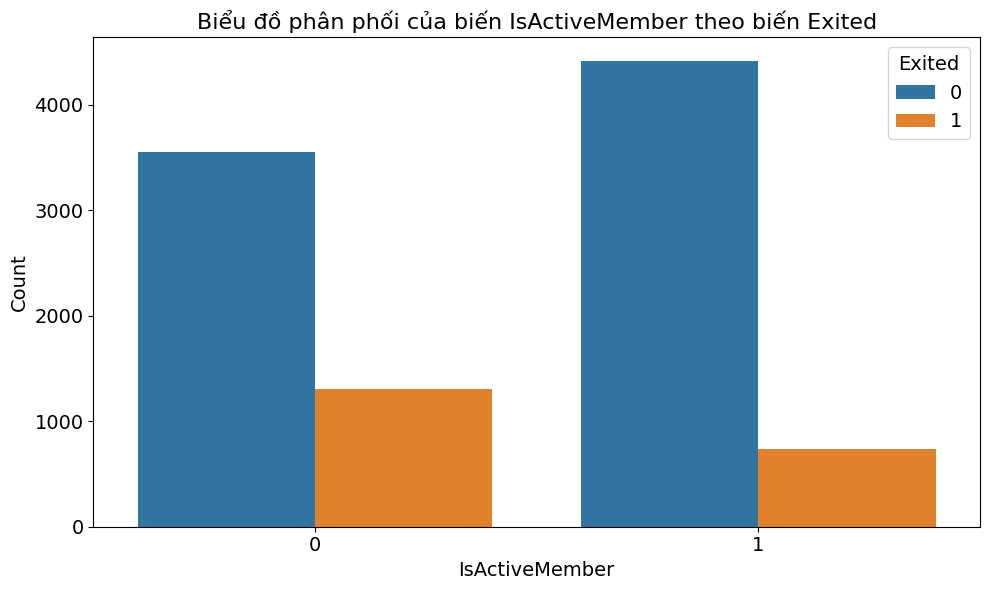

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df['IsActiveMember'], hue=df['Exited'])
plt.title('Biểu đồ phân phối của biến IsActiveMember theo biến Exited', fontsize=16)
plt.xlabel('IsActiveMember', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Exited', fontsize=14, title_fontsize=14)
plt.tight_layout()
plt.show()

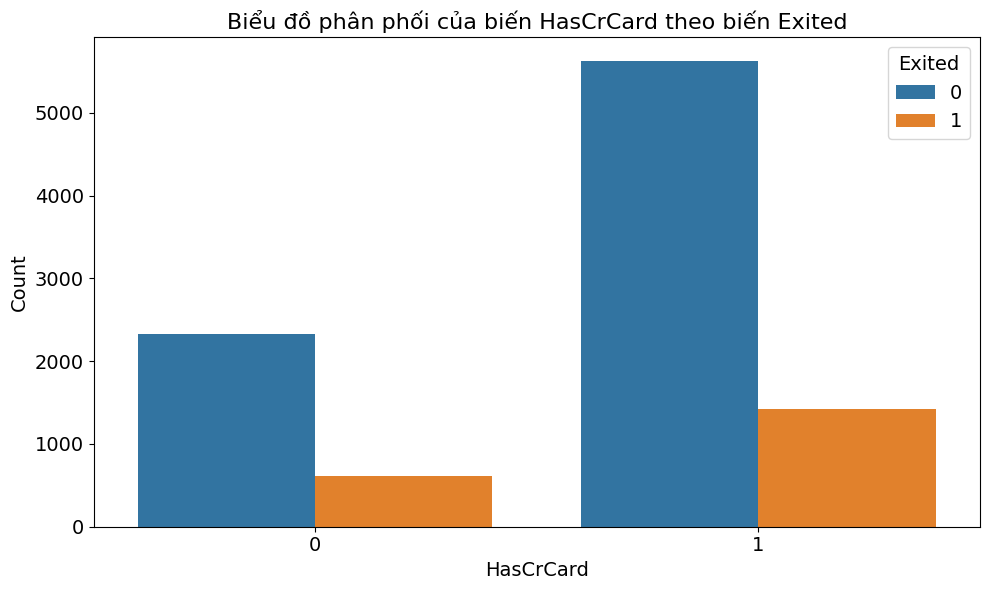

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df['HasCrCard'], hue=df['Exited'])
plt.title('Biểu đồ phân phối của biến HasCrCard theo biến Exited', fontsize=16)
plt.xlabel('HasCrCard', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Exited', fontsize=14, title_fontsize=14)
plt.tight_layout()
plt.show()

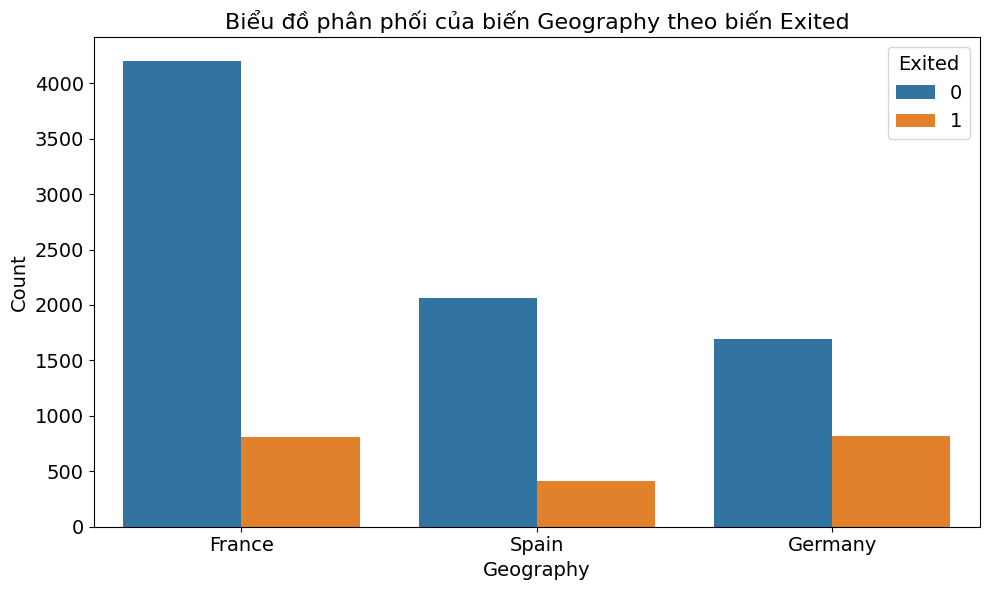

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df['Geography'], hue=df['Exited'])
plt.title('Biểu đồ phân phối của biến Geography theo biến Exited', fontsize=16)
plt.xlabel('Geography', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Exited', fontsize=14, title_fontsize=14)
plt.tight_layout()
plt.show()

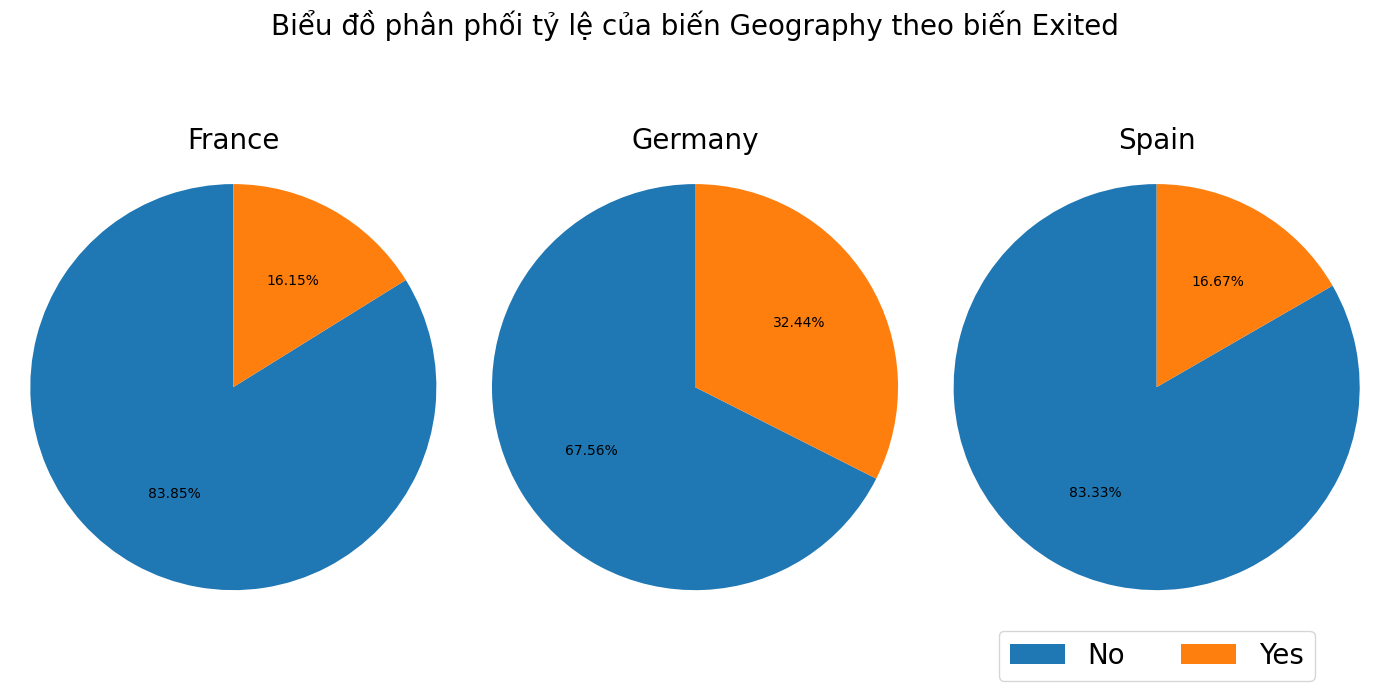

In [21]:
geography_exited_distribution = df.groupby(['Geography', 'Exited']).size().unstack()

fig, axes = plt.subplots(1, 3, figsize=(14, 7))

# Tạo pie chart cho mỗi giá trị của Geography
for i, geography in enumerate(geography_exited_distribution.index):
    axes[i].pie(geography_exited_distribution.loc[geography], autopct='%1.2f%%', startangle=90)
    axes[i].set_title(f'{geography}', fontsize=20)
    axes[i].axis('equal')

# Thêm tiêu đề cho toàn bộ figure
plt.suptitle('Biểu đồ phân phối tỷ lệ của biến Geography theo biến Exited', fontsize=20)

# Thay đổi vị trí của legend xuống dưới biểu đồ
plt.legend(labels=['No', 'Yes'], loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2, fontsize=20)

# Cải thiện layout của figure
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

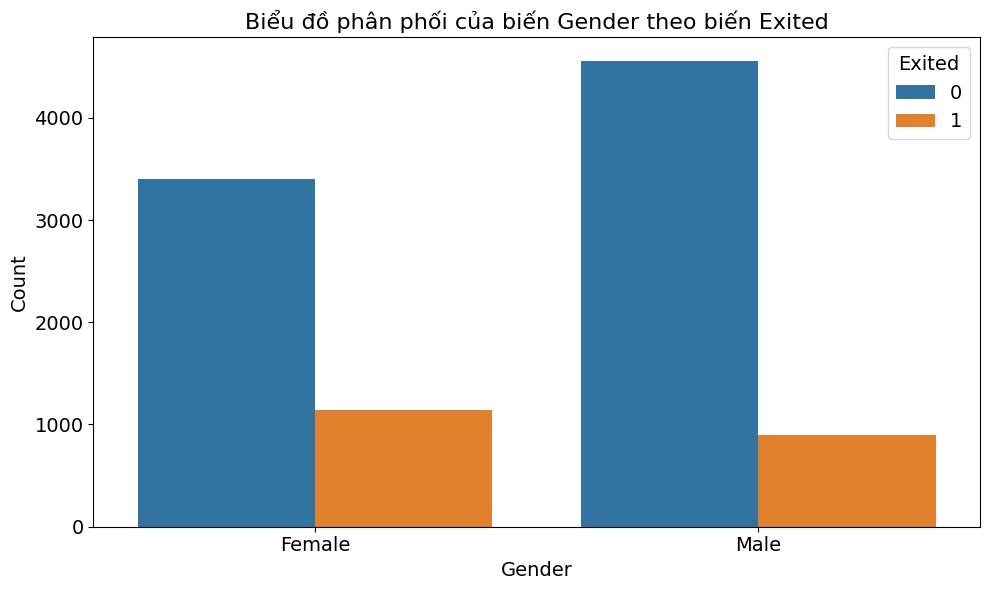

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df['Gender'], hue=df['Exited'])
plt.title('Biểu đồ phân phối của biến Gender theo biến Exited', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Exited', fontsize=14, title_fontsize=14)
plt.tight_layout()
plt.show()

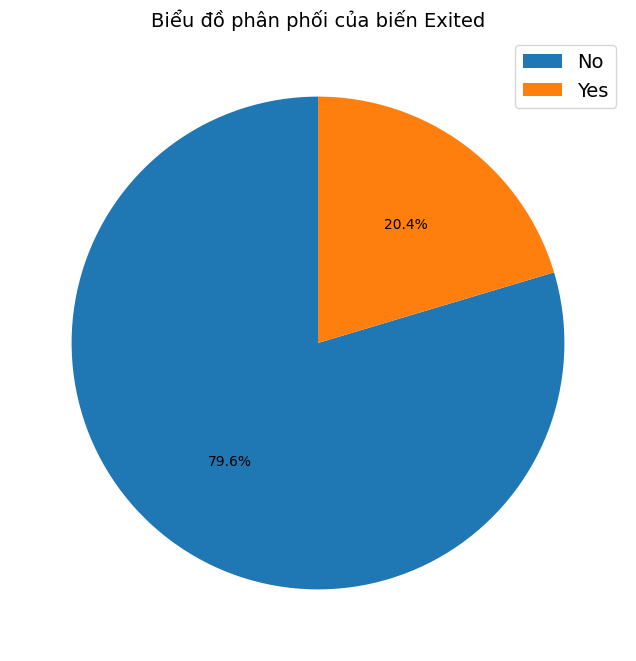

In [23]:
exited_distribution = df['Exited'].value_counts()
labels = ['No', 'Yes']
colors = ['#1f77b4', '#ff7f0e'] 
plt.figure(figsize=(8, 8))
plt.pie(exited_distribution, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Biểu đồ phân phối của biến Exited', fontsize = 14)
plt.legend(labels, loc="best", fontsize = 14)
plt.show()

*4.3. Phân tích mối quan hệ giữa các biến số và biến mục tiêu*

In [24]:
#Các biến số trong dữ liệu
features_num = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
df_selected_features = df[features_num]

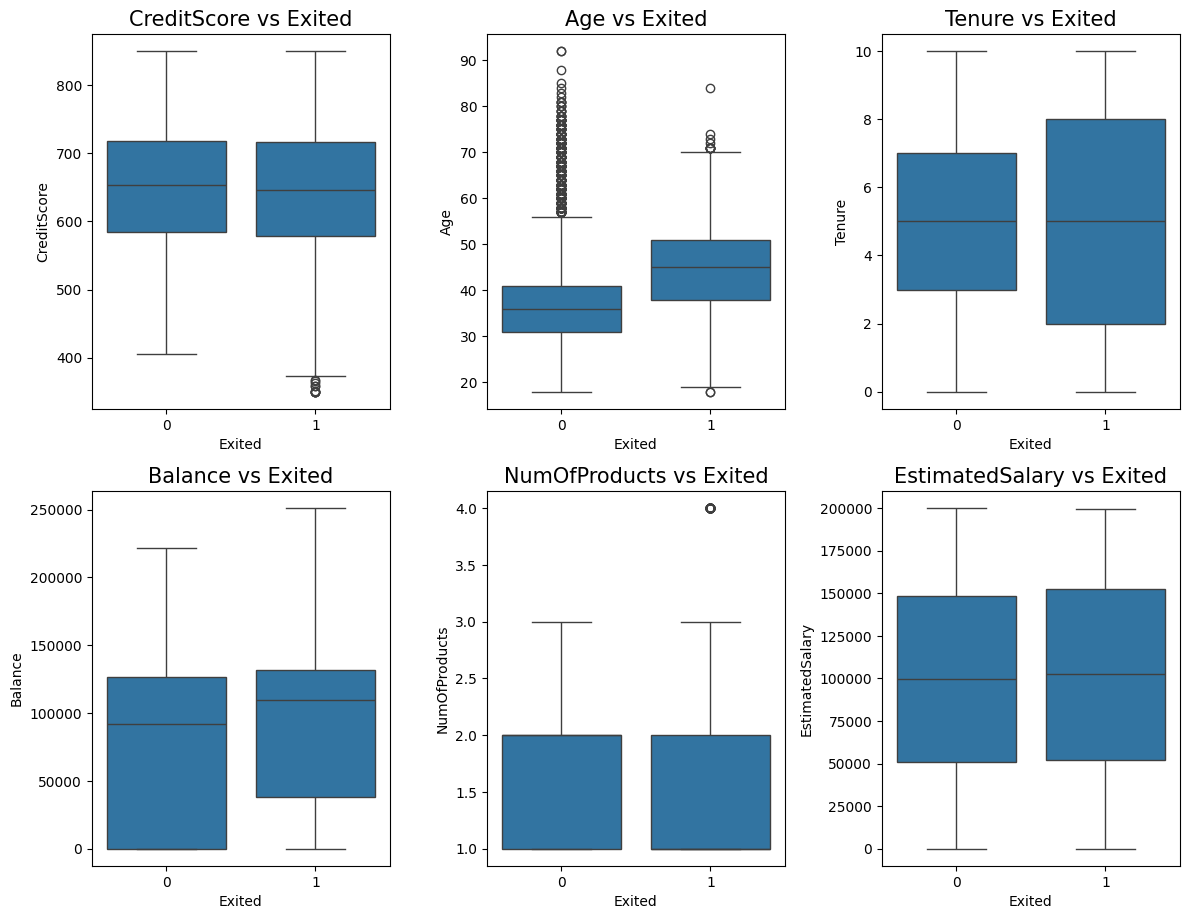

In [25]:
features_num = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
df_selected_features = df[features_num]
plt.figure(figsize=(12,18))
for i, column in enumerate(df_selected_features, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x='Exited', y=column, data=df)
    plt.title(f'{column} vs Exited', fontsize = 15)
plt.tight_layout()
plt.show()

**5. Preprocessing**

In [ ]:
# df = pd.read_csv("Data/Churn_Modelling.csv")
# df.head()

*5.1. Xóa cột không cần thiết*

In [26]:
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


*5.2. Chuyển đổi dữ liệu - Data Transformation*

In [27]:
from sklearn.preprocessing import LabelEncoder
# Chuyển đổi biến 'Gender' sử dụng Label Encoding
# 'Male' thành 1 và 'Female' thành 0)
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
df['Gender'].unique()
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0


In [28]:
df['Geography'] = df['Geography'].map({'France': 1, 'Spain': 2, 'Germany': 0})
print(df['Geography'].unique())
df.head()

[1 2 0]


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,1,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,1,0,42,8,159660.80,3,1,0,113931.57,1
3,699,1,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


*5.3. Phân tích tương quan trước xử lý outlier*

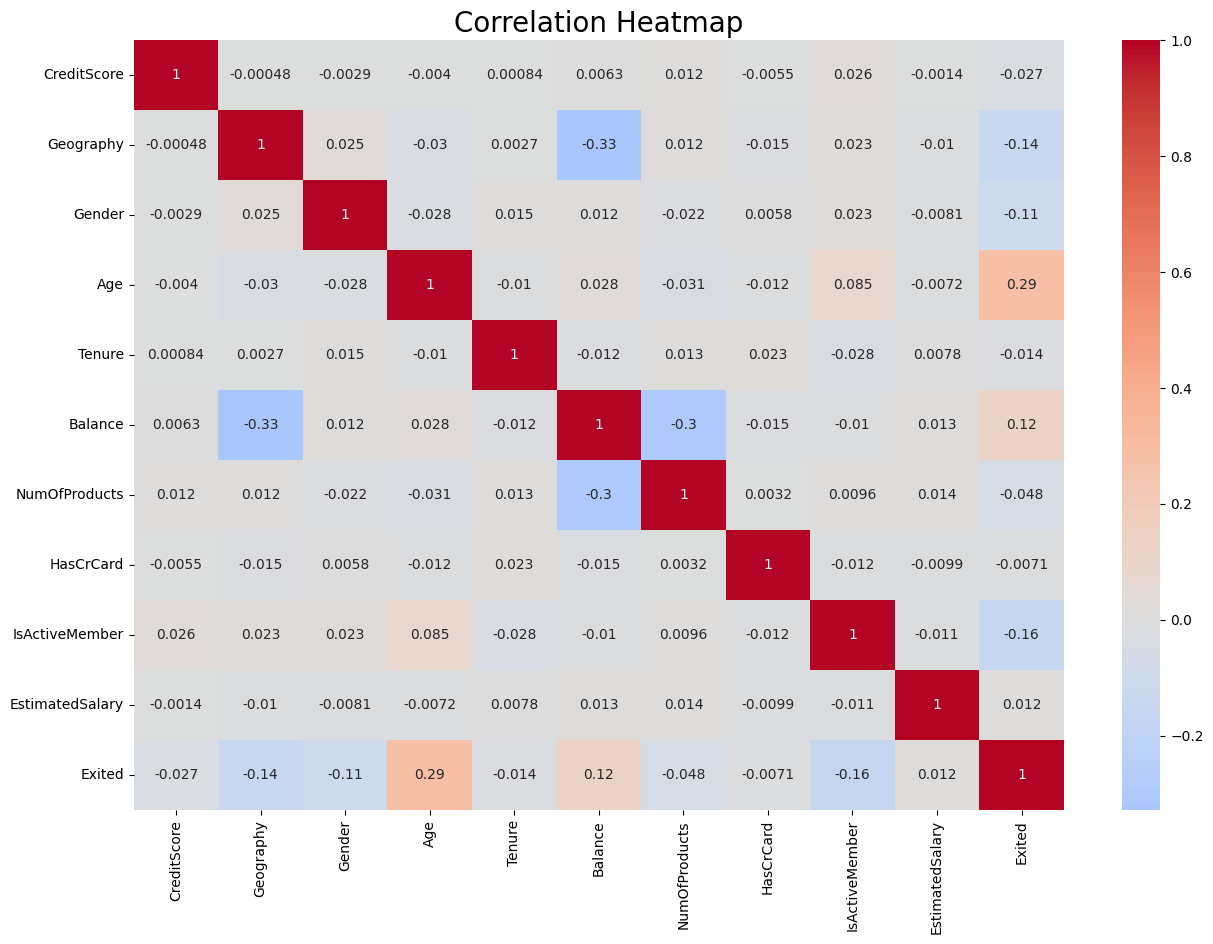

In [29]:
corr_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap', fontsize=20)
plt.show()

*5.2. Xác định kiểu biến*

In [30]:
#Các biến số trong dữ liệu
features_num = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
df_selected_features = df[features_num]

*5.3. Xử lý outlier*

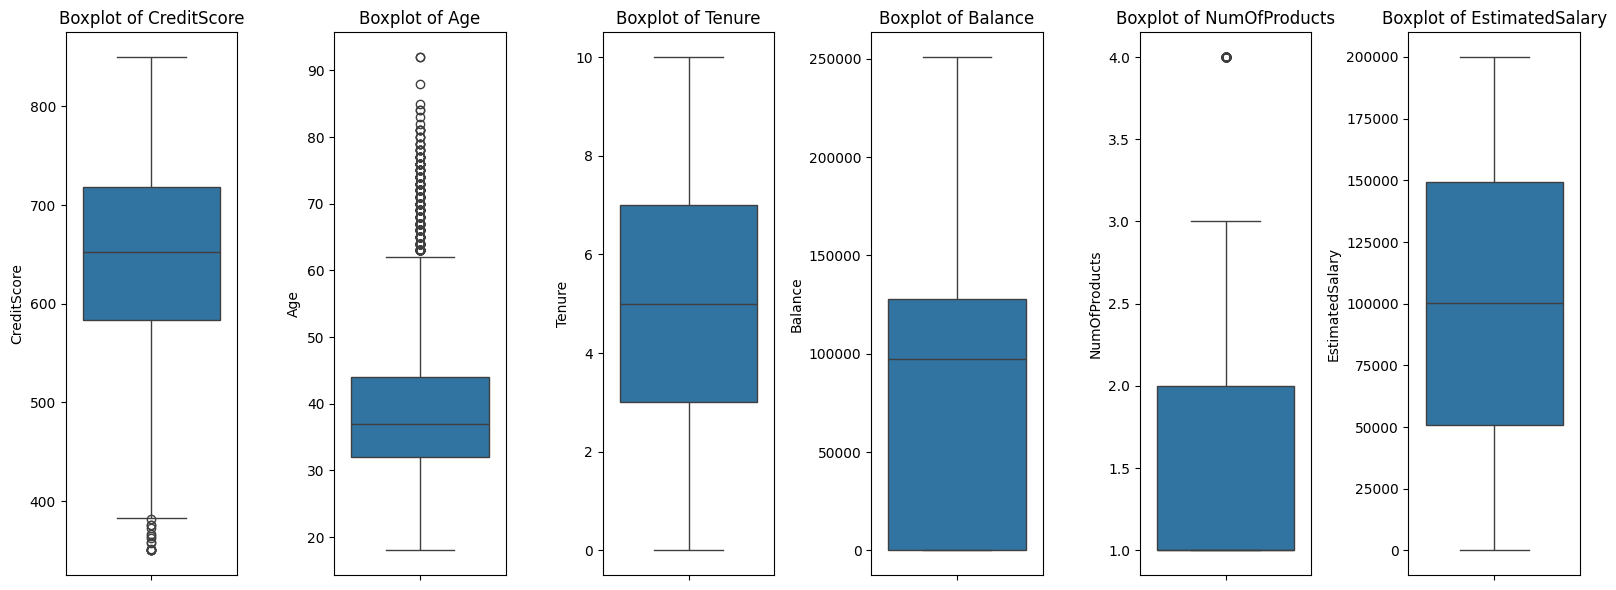

In [31]:
def detect_outliers_iqr(df):
    outliers = pd.DataFrame(columns=['Feature', 'Outliers'])
    for column in df.select_dtypes(include=['float64', 'int64']):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_data = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers = pd.concat([outliers, pd.DataFrame({'Feature': [column], 'Outliers': [outlier_data]})], ignore_index=True)
    return outliers

outliers_detected = detect_outliers_iqr(df_selected_features)

plt.figure(figsize=(16, 6))
for i, column in enumerate(features_num, 1):
    plt.subplot(1,6, i)
    sns.boxplot(df[column])
    plt.title(f'Boxplot of {column}', fontsize = 12)
plt.tight_layout()
plt.show()

In [32]:
def clip_outliers_using_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

for feature in features_num:
    clip_outliers_using_IQR(df_selected_features, feature)
df[features_num] = df_selected_features[features_num]

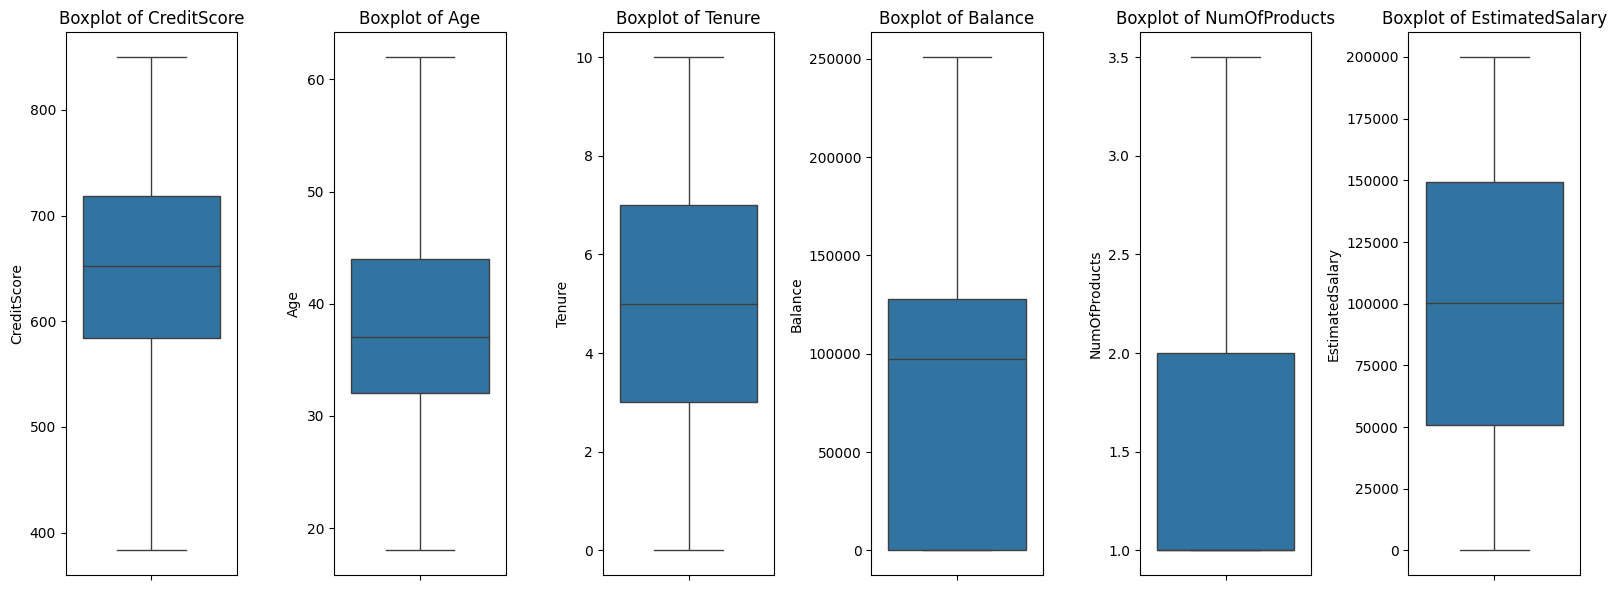

In [48]:
plt.figure(figsize=(16, 6))
for i, column in enumerate(features_num, 1):
    plt.subplot(1, 6, i)
    sns.boxplot(df[column])
    plt.title(f'Boxplot of {column}', fontsize=12)
plt.tight_layout()
plt.show()

*5.5. Phân tích tương quan sau xử lý outlier*

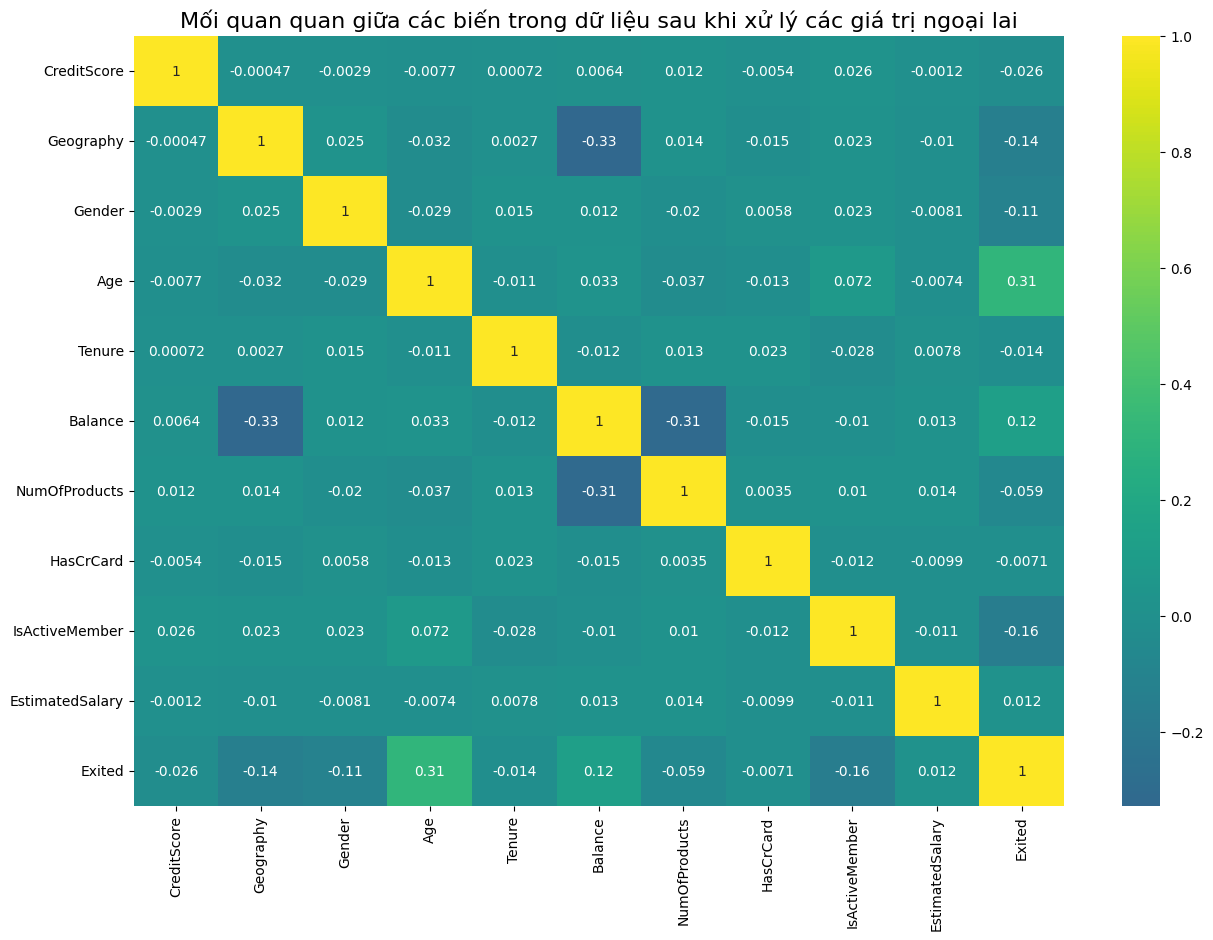

In [33]:
corr_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', center=0)
plt.title('Mối quan quan giữa các biến trong dữ liệu sau khi xử lý các giá trị ngoại lai', fontsize=16)
plt.show()

**6. Kết quả**

In [34]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,1,0,42,2,0.00,1.0,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1.0,0,1,112542.58,0
2,502,1,0,42,8,159660.80,3.0,1,0,113931.57,1
3,699,1,0,39,1,0.00,2.0,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1.0,1,1,79084.10,0


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  int64  
 2   Gender           10000 non-null  int32  
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  float64
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int32(1), int64(7)
memory usage: 820.4 KB


****7. Chia dữ liệu****

In [36]:
X = df[['Age', 'IsActiveMember', 'Balance', 'Geography', 'Gender']]
y = df['Exited']

*Phân chia 8:2*

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [40]:
# In ra số lượng các mẫu sau khi sử dụng SMOTE
print(f"Số lượng mẫu trước khi SMOTE: {Counter(y_train)}")
print(f"Số lượng mẫu sau khi SMOTE: {Counter(y_train_resampled)}")

Số lượng mẫu trước khi SMOTE: Counter({0: 6356, 1: 1644})
Số lượng mẫu sau khi SMOTE: Counter({0: 6356, 1: 6356})


****Modeling****

**+++ Tìm kiếm siêu tham số với X_train, y_train (tối ưu hóa Accurracy)**

In [204]:

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# Tạo grid cho siêu tham số n_neighbors
param_grid_knn = {'n_neighbors': [3, 5, 7, 9, 11, 13]}
# Tạo đối tượng GridSearchCV cho k-NN
grid_search_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)
# In ra siêu tham số tốt nhất và kết quả tương ứng
print("Best n_neighbors for k-NN:", grid_search_knn.best_params_)
print("Best accuracy for k-NN:", grid_search_knn.best_score_)
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# Tạo grid cho siêu tham số C và gamma
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']}
# Tạo đối tượng GridSearchCV cho SVM
grid_search_svm = GridSearchCV(estimator=SVC(), param_grid=param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train, y_train)
# In ra siêu tham số tốt nhất và kết quả tương ứng
print("Best parameters for SVM:", grid_search_svm.best_params_)
print("Best accuracy for SVM:", grid_search_svm.best_score_)
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------

# Tạo grid cho siêu tham số max_depth
param_grid_dt = {'max_depth': [3, 5, 7, 9, 11, 13, 15]}
# Tạo đối tượng GridSearchCV cho Decision Tree
grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)
# In ra siêu tham số tốt nhất và kết quả tương ứng
print("Best max_depth for Decision Tree:", grid_search_dt.best_params_)
print("Best accuracy for Decision Tree:", grid_search_dt.best_score_)
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# Tạo grid cho siêu tham số max_depth và n_estimators
param_grid_rf = {
    'max_depth': [3, 5, 7, 9, 11, 13, 15],
    'n_estimators': [50, 100, 200, 300]}
# Tạo đối tượng GridSearchCV cho Random Forest
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)
# In ra siêu tham số tốt nhất và kết quả tương ứng
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best accuracy for Random Forest:", grid_search_rf.best_score_)
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# Tạo grid cho siêu tham số hidden_layer_sizes và max_iter
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (100, 100)],
    'max_iter': [200, 300, 400]}
# Tạo đối tượng GridSearchCV cho Neural Network
grid_search_nn = GridSearchCV(estimator=MLPClassifier(random_state=42), param_grid=param_grid_nn, cv=5, scoring='accuracy')
grid_search_nn.fit(X_train, y_train)
# In ra siêu tham số tốt nhất và kết quả tương ứng
print("Best parameters for Neural Network:", grid_search_nn.best_params_)
print("Best accuracy for Neural Network:", grid_search_nn.best_score_)

Best n_neighbors for k-NN: {'n_neighbors': 13}
Best accuracy for k-NN: 0.793125
Best parameters for SVM: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best accuracy for SVM: 0.8
Best max_depth for Decision Tree: {'max_depth': 5}
Best accuracy for Decision Tree: 0.8314999999999999
Best parameters for Random Forest: {'max_depth': 5, 'n_estimators': 200}
Best accuracy for Random Forest: 0.835875
Best parameters for Neural Network: {'hidden_layer_sizes': (50,), 'max_iter': 200}
Best accuracy for Neural Network: 0.7312500000000001


**+++ Tìm kiếm siêu tham số với X_train_resampled, y_train_resampled (tối ưu hóa Accurracy)**

In [236]:
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# Tạo grid cho siêu tham số C và gamma
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']}
# Tạo đối tượng GridSearchCV cho SVM
grid_search_svm = GridSearchCV(estimator=SVC(), param_grid=param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train_resampled, y_train_resampled)
# In ra siêu tham số tốt nhất và kết quả tương ứng
print("Best parameters for SVM:", grid_search_svm.best_params_)
print("Best accuracy for SVM:", grid_search_svm.best_score_)
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# Tạo grid cho siêu tham số max_depth
param_grid_dt = {'max_depth': [3, 5, 7, 9, 11, 13, 15]}
# Tạo đối tượng GridSearchCV cho Decision Tree
grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train_resampled, y_train_resampled)
# In ra siêu tham số tốt nhất và kết quả tương ứng
print("Best max_depth for Decision Tree:", grid_search_dt.best_params_)
print("Best accuracy for Decision Tree:", grid_search_dt.best_score_)
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# Tạo grid cho siêu tham số max_depth và n_estimators
param_grid_rf = {
    'max_depth': [3, 5, 7, 9, 11, 13, 15],
    'n_estimators': [50, 100, 200, 300]}
# Tạo đối tượng GridSearchCV cho Random Forest
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_resampled, y_train_resampled)
# In ra siêu tham số tốt nhất và kết quả tương ứng
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best accuracy for Random Forest:", grid_search_rf.best_score_)
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# Tạo grid cho siêu tham số hidden_layer_sizes và max_iter
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (100, 100)],
    'max_iter': [200, 300, 400]}
# Tạo đối tượng GridSearchCV cho Neural Network
grid_search_nn = GridSearchCV(estimator=MLPClassifier(random_state=42), param_grid=param_grid_nn, cv=5, scoring='accuracy')
grid_search_nn.fit(X_train_resampled, y_train_resampled)
# In ra siêu tham số tốt nhất và kết quả tương ứng
print("Best parameters for Neural Network:", grid_search_nn.best_params_)
print("Best accuracy for Neural Network:", grid_search_nn.best_score_)

Best parameters for SVM: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best accuracy for SVM: 0.7065766379252467
Best max_depth for Decision Tree: {'max_depth': 9}
Best accuracy for Decision Tree: 0.7854056723181111
Best parameters for Random Forest: {'max_depth': 9, 'n_estimators': 300}
Best accuracy for Random Forest: 0.7966553872913813
Best parameters for Neural Network: {'hidden_layer_sizes': (100,), 'max_iter': 200}
Best accuracy for Neural Network: 0.5920383719458825


**--Hàm chia theo 8:2**

In [41]:
def evaluate_model(model, X_train, y_train, X_test, X_train_resampled, y_train_resampled, y_test, resample=False):
    if resample:
        model.fit(X_train_resampled, y_train_resampled)
    else:
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(classification_report(y_test, y_pred))
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(f'F-score: {f1}')
    print(f'ROC-AUC: {roc_auc}')

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    return

**--Hàm chia theo K-Fold**

In [42]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import numpy as np

def evaluate_model_with_kfold(model, n_splits, X, y):
    kf = KFold(n_splits = n_splits)
    
    accuracies = []
    recalls = []
    precisions = []
    f1_scores = []
    roc_aucs = []

    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index] 
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        
        # Áp dụng SMOTE trên tập huấn luyện
        sm = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
        
        # Huấn luyện mô hình
        model.fit(X_train_resampled, y_train_resampled)

        # Dự đoán và đánh giá trên tập kiểm tra
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        # Tính toán các chỉ số
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)
        
        # Lưu trữ kết quả vào danh sách
        accuracies.append(accuracy)
        recalls.append(recall)
        precisions.append(precision)
        f1_scores.append(f1)
        roc_aucs.append(roc_auc)
        
        # In kết quả của từng fold
        print(f'For fold {fold}:')
        print(f'Accuracy: {accuracy}')
        print(f'Recall: {recall}')
        print(f'Precision: {precision}')
        print(f'f1-score: {f1}')
        print(f'ROC-AUC: {roc_auc}')

    # Tính trung bình các chỉ số qua các fold
    mean_accuracy = np.mean(accuracies)
    mean_recall = np.mean(recalls)
    mean_precision = np.mean(precisions)
    mean_f1 = np.mean(f1_scores)
    mean_roc_auc = np.mean(roc_aucs)

    # In kết quả trung bình
    print('\nAverage metrics over all folds:')
    print(f'Average Accuracy: {mean_accuracy}')
    print(f'Average Recall: {mean_recall}')
    print(f'Average Precision: {mean_precision}')
    print(f'Average F1-Score: {mean_f1}')
    print(f'Average ROC-AUC: {mean_roc_auc}')

    return 


**1. KNN**

In [ ]:
model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train_resampled, y_train_resampled)

y_pred_knn = model.predict(X_test)
y_prob_knn = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)
roc_auc = roc_auc_score(y_test, y_prob_knn)

print(classification_report(y_test, y_pred_knn))
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F-score: {f1}')
print(f'ROC-AUC: {roc_auc}')

In [301]:
model = KNeighborsClassifier(n_neighbors=3)

folds = [3, 5, 7, 10]

best_score = 0
best_fold = 0

for fold in folds:
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=fold, scoring='accuracy')
    mean_score = np.mean(scores)
    print(f'Number of folds: {fold}, Cross-validated accuracy: {mean_score}')
    
    if mean_score > best_score:
        best_score = mean_score
        best_fold = fold

print(f'\nBest number of folds: {best_fold}')
print(f'Best cross-validated accuracy: {best_score}')

Number of folds: 3, Cross-validated accuracy: 0.6796011325498835
Number of folds: 5, Cross-validated accuracy: 0.6849539774294799
Number of folds: 7, Cross-validated accuracy: 0.6832214674925927
Number of folds: 10, Cross-validated accuracy: 0.6844036873439601

Best number of folds: 5
Best cross-validated accuracy: 0.6849539774294799


In [302]:
model = KNeighborsClassifier(n_neighbors=3)
evaluate_model_with_kfold(model, 5, X, y)

For fold 1:
Accuracy: 0.6445
Recall: 0.40384615384615385
Precision: 0.2662440570522979
f1-score: 0.32091690544412604
ROC-AUC: 0.586118091977467
For fold 2:
Accuracy: 0.6625
Recall: 0.47674418604651164
Precision: 0.31297709923664124
f1-score: 0.3778801843317972
ROC-AUC: 0.6148533550585099
For fold 3:
Accuracy: 0.6575
Recall: 0.41687344913151364
Precision: 0.27184466019417475
f1-score: 0.32908912830558273
ROC-AUC: 0.6052663881253778
For fold 4:
Accuracy: 0.6715
Recall: 0.44221105527638194
Precision: 0.28805237315875615
f1-score: 0.34886025768087214
ROC-AUC: 0.6155535793825557
For fold 5:
Accuracy: 0.671
Recall: 0.45897435897435895
Precision: 0.28594249201277955
f1-score: 0.35236220472440943
ROC-AUC: 0.6125465838509316

Average metrics over all folds:
Average Accuracy: 0.6614000000000001
Average Recall: 0.439729840654984
Average Precision: 0.2850121363309299
Average F1-Score: 0.34582173609735756
Average ROC-AUC: 0.6068675996789683


**2.SVM**

Có sử dụng SMOTE để xử lý mất cân bằng
----------------------
              precision    recall  f1-score   support

           0       0.85      0.73      0.78      1607
           1       0.30      0.47      0.36       393

    accuracy                           0.68      2000
   macro avg       0.57      0.60      0.57      2000
weighted avg       0.74      0.68      0.70      2000

Accuracy: 0.6765
Recall: 0.4681933842239186
Precision: 0.2958199356913183
F-score: 0.3625615763546798
ROC-AUC: 0.6389341478360417


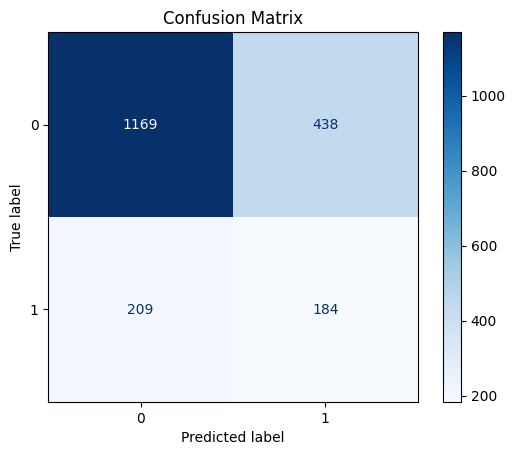

In [56]:
print("Có sử dụng SMOTE để xử lý mất cân bằng")
print("-----------"*2)
model = SVC(C=10, gamma=0.001, kernel='rbf', probability=True)
evaluate_model(model, X_train, y_train, X_test, X_train_resampled, y_train_resampled, y_test, resample=True)

In [303]:
model = SVC(C=10, gamma=0.001, kernel='rbf', probability=True)
folds = [3, 5, 7, 10]

best_score = 0
best_fold = 0

for fold in folds:
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=fold, scoring='accuracy')
    mean_score = np.mean(scores)
    print(f'Number of folds: {fold}, Cross-validated accuracy: {mean_score}')
    
    if mean_score > best_score:
        best_score = mean_score
        best_fold = fold

print(f'\nBest number of folds: {best_fold}')
print(f'Best cross-validated accuracy: {best_score}')

Number of folds: 3, Cross-validated accuracy: 0.7044702386062159
Number of folds: 5, Cross-validated accuracy: 0.7095860461213441
Number of folds: 7, Cross-validated accuracy: 0.7078538401926467
Number of folds: 10, Cross-validated accuracy: 0.7129709386248041

Best number of folds: 10
Best cross-validated accuracy: 0.7129709386248041


In [304]:
model = SVC(C=10, gamma=0.001, kernel='rbf', probability=True)
evaluate_model_with_kfold(model, 10, X, y)

For fold 1:
Accuracy: 0.683
Recall: 0.5098039215686274
Precision: 0.32398753894080995
f1-score: 0.39619047619047615
ROC-AUC: 0.6766614937432258
For fold 2:
Accuracy: 0.665
Recall: 0.42924528301886794
Precision: 0.2983606557377049
f1-score: 0.35203094777562866
ROC-AUC: 0.6137672397279954
For fold 3:
Accuracy: 0.649
Recall: 0.4583333333333333
Precision: 0.2972972972972973
f1-score: 0.36065573770491804
ROC-AUC: 0.614550855064248
For fold 4:
Accuracy: 0.704
Recall: 0.49065420560747663
Precision: 0.3595890410958904
f1-score: 0.4150197628458498
ROC-AUC: 0.6566193431785212
For fold 5:
Accuracy: 0.683
Recall: 0.515
Precision: 0.3188854489164087
f1-score: 0.39388145315487577
ROC-AUC: 0.65363125
For fold 6:
Accuracy: 0.667
Recall: 0.458128078817734
Precision: 0.29430379746835444
f1-score: 0.35838150289017345
ROC-AUC: 0.6313886433732407
For fold 7:
Accuracy: 0.671
Recall: 0.4742268041237113
Precision: 0.2884012539184953
f1-score: 0.3586744639376218
ROC-AUC: 0.6392839784093525
For fold 8:
Accuracy

**3.Decision Tree**

Có sử dụng SMOTE để xử lý mất cân bằng
----------------------
              precision    recall  f1-score   support

           0       0.89      0.80      0.85      1607
           1       0.43      0.61      0.50       393

    accuracy                           0.77      2000
   macro avg       0.66      0.71      0.68      2000
weighted avg       0.80      0.77      0.78      2000

Accuracy: 0.7655
Recall: 0.6055979643765903
Precision: 0.4311594202898551
F-score: 0.5037037037037037
ROC-AUC: 0.755505097767243


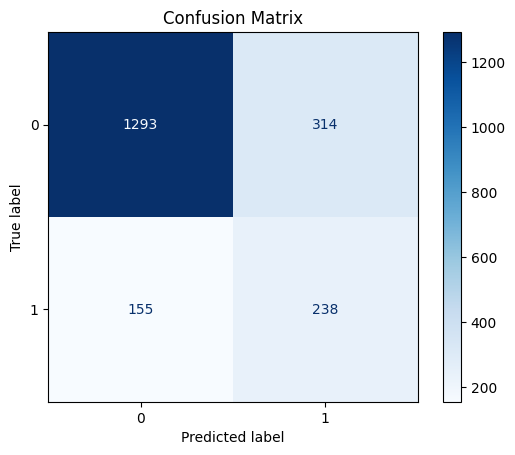

In [57]:
print("Có sử dụng SMOTE để xử lý mất cân bằng")
print("-----------"*2)
model = DecisionTreeClassifier(max_depth=9)
evaluate_model(model, X_train, y_train, X_test, X_train_resampled, y_train_resampled, y_test, resample=True)

In [308]:
model = DecisionTreeClassifier(max_depth=9)
folds = [3, 5, 7, 10]

best_score = 0
best_fold = 0

for fold in folds:
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=fold, scoring='accuracy')
    mean_score = np.mean(scores)
    print(f'Number of folds: {fold}, Cross-validated accuracy: {mean_score}')
    
    if mean_score > best_score:
        best_score = mean_score
        best_fold = fold

print(f'\nBest number of folds: {best_fold}')
print(f'Best cross-validated accuracy: {best_score}')


Number of folds: 3, Cross-validated accuracy: 0.7823108573688023
Number of folds: 5, Cross-validated accuracy: 0.7852249078913837
Number of folds: 7, Cross-validated accuracy: 0.7878217497360469
Number of folds: 10, Cross-validated accuracy: 0.7879035665388404

Best number of folds: 10
Best cross-validated accuracy: 0.7879035665388404


In [312]:
model = DecisionTreeClassifier(max_depth=9)
evaluate_model_with_kfold(model, 10, X, y)

For fold 1:
Accuracy: 0.763
Recall: 0.6568627450980392
Precision: 0.44518272425249167
f1-score: 0.5306930693069307
ROC-AUC: 0.7828573012119421
For fold 2:
Accuracy: 0.763
Recall: 0.5377358490566038
Precision: 0.4505928853754941
f1-score: 0.49032258064516127
ROC-AUC: 0.7214706445742743
For fold 3:
Accuracy: 0.761
Recall: 0.6666666666666666
Precision: 0.4630225080385852
f1-score: 0.5464895635673624
ROC-AUC: 0.7851621551398338
For fold 4:
Accuracy: 0.768
Recall: 0.5887850467289719
Precision: 0.4666666666666667
f1-score: 0.5206611570247933
ROC-AUC: 0.76158117523959
For fold 5:
Accuracy: 0.728
Recall: 0.605
Precision: 0.3853503184713376
f1-score: 0.47081712062256814
ROC-AUC: 0.7667687500000001
For fold 6:
Accuracy: 0.768
Recall: 0.6157635467980296
Precision: 0.44802867383512546
f1-score: 0.5186721991701244
ROC-AUC: 0.7369291246113814
For fold 7:
Accuracy: 0.769
Recall: 0.6082474226804123
Precision: 0.43223443223443225
f1-score: 0.5053533190578159
ROC-AUC: 0.7566991123276458
For fold 8:
Accu

**4. Random Forest**

Có sử dụng SMOTE để xử lý mất cân bằng
----------------------
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1607
           1       0.45      0.62      0.52       393

    accuracy                           0.77      2000
   macro avg       0.67      0.72      0.69      2000
weighted avg       0.81      0.77      0.79      2000

Accuracy: 0.7745
Recall: 0.6234096692111959
Precision: 0.4470802919708029
F-score: 0.5207226354941551
ROC-AUC: 0.7965603727964963


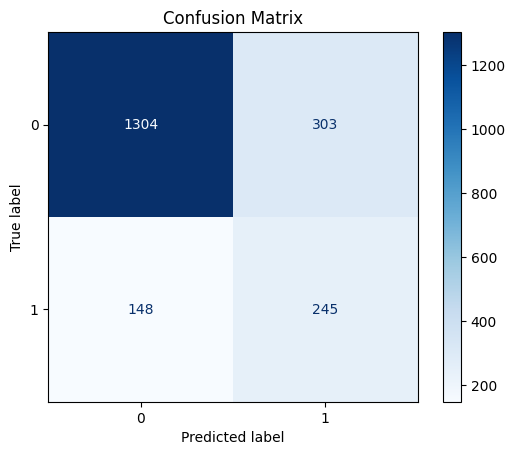

In [58]:
print("Có sử dụng SMOTE để xử lý mất cân bằng")
print("-----------"*2)
model = RandomForestClassifier(n_estimators=300, max_depth=9, random_state=42)
evaluate_model(model, X_train, y_train, X_test, X_train_resampled, y_train_resampled, y_test, resample=True)


In [309]:
model = RandomForestClassifier(n_estimators=300, max_depth=9, random_state=42)
folds = [3, 5, 7, 10]

best_score = 0
best_fold = 0

for fold in folds:
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=fold, scoring='accuracy')
    mean_score = np.mean(scores)
    print(f'Number of folds: {fold}, Cross-validated accuracy: {mean_score}')
    
    if mean_score > best_score:
        best_score = mean_score
        best_fold = fold

print(f'\nBest number of folds: {best_fold}')
print(f'Best cross-validated accuracy: {best_score}')


Number of folds: 3, Cross-validated accuracy: 0.7956913047178306
Number of folds: 5, Cross-validated accuracy: 0.8028546781640266
Number of folds: 7, Cross-validated accuracy: 0.8019100409669092
Number of folds: 10, Cross-validated accuracy: 0.803408005352596

Best number of folds: 10
Best cross-validated accuracy: 0.803408005352596


In [311]:
model = RandomForestClassifier(n_estimators=300, max_depth=9, random_state=42)
evaluate_model_with_kfold(model, 10, X, y)

For fold 1:
Accuracy: 0.785
Recall: 0.6274509803921569
Precision: 0.4794007490636704
f1-score: 0.5435244161358811
ROC-AUC: 0.7824600945906001
For fold 2:
Accuracy: 0.784
Recall: 0.5518867924528302
Precision: 0.49159663865546216
f1-score: 0.52
ROC-AUC: 0.7729922900105354
For fold 3:
Accuracy: 0.775
Recall: 0.6527777777777778
Precision: 0.4845360824742268
f1-score: 0.5562130177514792
ROC-AUC: 0.798286328420257
For fold 4:
Accuracy: 0.78
Recall: 0.5981308411214953
Precision: 0.48854961832061067
f1-score: 0.5378151260504201
ROC-AUC: 0.793613707165109
For fold 5:
Accuracy: 0.761
Recall: 0.605
Precision: 0.4306049822064057
f1-score: 0.503118503118503
ROC-AUC: 0.7869499999999999
For fold 6:
Accuracy: 0.796
Recall: 0.6108374384236454
Precision: 0.4979919678714859
f1-score: 0.5486725663716814
ROC-AUC: 0.7786310734218838
For fold 7:
Accuracy: 0.781
Recall: 0.6134020618556701
Precision: 0.4524714828897338
f1-score: 0.5207877461706784
ROC-AUC: 0.7802371389833977
For fold 8:
Accuracy: 0.772
Recall:

**5. Neural Network**

Có sử dụng SMOTE để xử lý mất cân bằng
----------------------
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1607
           1       0.32      0.13      0.19       393

    accuracy                           0.78      2000
   macro avg       0.57      0.53      0.53      2000
weighted avg       0.72      0.78      0.74      2000

Accuracy: 0.776
Recall: 0.1297709923664122
Precision: 0.3248407643312102
F-score: 0.18545454545454546
ROC-AUC: 0.5119087769633807


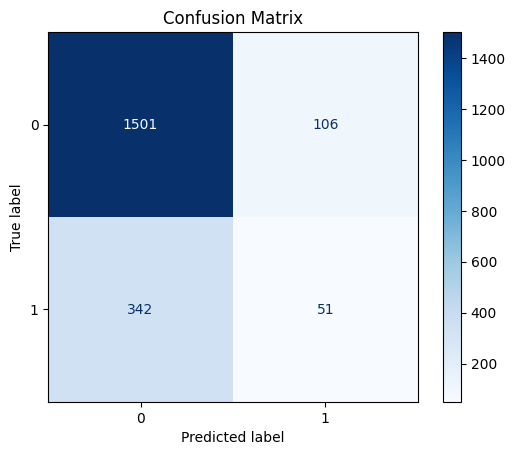

In [59]:
print("Có sử dụng SMOTE để xử lý mất cân bằng")
print("-----------"*2)
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=200)
evaluate_model(model, X_train, y_train, X_test, X_train_resampled, y_train_resampled, y_test, resample=True)

In [313]:
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=200)
folds = [3, 5, 7, 10]

best_score = 0
best_fold = 0

for fold in folds:
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=fold, scoring='accuracy')
    mean_score = np.mean(scores)
    print(f'Number of folds: {fold}, Cross-validated accuracy: {mean_score}')
    
    if mean_score > best_score:
        best_score = mean_score
        best_fold = fold

print(f'\nBest number of folds: {best_fold}')
print(f'Best cross-validated accuracy: {best_score}')

Number of folds: 3, Cross-validated accuracy: 0.5602888827199927
Number of folds: 5, Cross-validated accuracy: 0.5977541258064826
Number of folds: 7, Cross-validated accuracy: 0.5702057620659943
Number of folds: 10, Cross-validated accuracy: 0.5706091056084551

Best number of folds: 5
Best cross-validated accuracy: 0.5977541258064826


In [315]:
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=200)
evaluate_model_with_kfold(model,5, X, y)

For fold 1:
Accuracy: 0.4285
Recall: 0.8870192307692307
Precision: 0.25187713310580206
f1-score: 0.39234449760765555
ROC-AUC: 0.589034880050505
For fold 2:
Accuracy: 0.7615
Recall: 0.11627906976744186
Precision: 0.3401360544217687
f1-score: 0.1733102253032929
ROC-AUC: 0.47226040586579765
For fold 3:
Accuracy: 0.4475
Recall: 0.8808933002481389
Precision: 0.2514164305949009
f1-score: 0.39118457300275483
ROC-AUC: 0.7010632529044067
For fold 4:
Accuracy: 0.43
Recall: 0.907035175879397
Precision: 0.2465846994535519
f1-score: 0.38775510204081626
ROC-AUC: 0.6078402311181376
For fold 5:
Accuracy: 0.4145
Recall: 0.8846153846153846
Precision: 0.2345343303874915
f1-score: 0.37076840408382583
ROC-AUC: 0.601262143653448

Average metrics over all folds:
Average Accuracy: 0.49639999999999995
Average Recall: 0.7351684322559187
Average Precision: 0.264909729592703
Average F1-Score: 0.3430725604076691
Average ROC-AUC: 0.594292182718459


****CHIA 8:2 - KHÔNG SỬ DỤNG SMOTE****

In [316]:
print("Không sử dụng SMOTE")
print("-----------"*2)
model = KNeighborsClassifier(n_neighbors=13)
evaluate_model(model, X_train, y_train, X_test, X_train_resampled, y_train_resampled, y_test, resample=False)

Không sử dụng SMOTE
----------------------
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1610
           1       0.41      0.07      0.12       390

    accuracy                           0.80      2000
   macro avg       0.61      0.52      0.50      2000
weighted avg       0.73      0.80      0.74      2000

Accuracy: 0.799
Recall: 0.06923076923076923
Precision: 0.4090909090909091
F-score: 0.11842105263157895
ROC-AUC: 0.605406911928651


In [317]:
print("Không sử dụng SMOTE")
print("-----------"*2)
model = SVC(C=10, gamma=0.001, kernel='rbf', probability=True)
evaluate_model(model, X_train, y_train, X_test, X_train_resampled, y_train_resampled, y_test, resample=False)

Không sử dụng SMOTE
----------------------
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1610
           1       0.29      0.19      0.23       390

    accuracy                           0.75      2000
   macro avg       0.55      0.54      0.54      2000
weighted avg       0.72      0.75      0.73      2000

Accuracy: 0.75
Recall: 0.19487179487179487
Precision: 0.2900763358778626
F-score: 0.2331288343558282
ROC-AUC: 0.6041630832935181


In [318]:
print("Không sử dụng SMOTE")
print("-----------"*2)
model = DecisionTreeClassifier(max_depth=9)
evaluate_model(model, X_train, y_train, X_test, X_train_resampled, y_train_resampled, y_test, resample=False)

Không sử dụng SMOTE
----------------------
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1610
           1       0.54      0.36      0.43       390

    accuracy                           0.82      2000
   macro avg       0.70      0.64      0.66      2000
weighted avg       0.80      0.82      0.80      2000

Accuracy: 0.8155
Recall: 0.3641025641025641
Precision: 0.5399239543726235
F-score: 0.43491577335375187
ROC-AUC: 0.7514819238732282


In [319]:
print("Không sử dụng SMOTE")
print("-----------"*2)
model = RandomForestClassifier(n_estimators=300, max_depth=9, random_state=42)
evaluate_model(model, X_train, y_train, X_test, X_train_resampled, y_train_resampled, y_test, resample=False)

Không sử dụng SMOTE
----------------------
              precision    recall  f1-score   support

           0       0.86      0.96      0.90      1610
           1       0.66      0.35      0.46       390

    accuracy                           0.84      2000
   macro avg       0.76      0.65      0.68      2000
weighted avg       0.82      0.84      0.82      2000

Accuracy: 0.838
Recall: 0.35128205128205126
Precision: 0.6586538461538461
F-score: 0.45819397993311034
ROC-AUC: 0.7805996177735308


In [320]:
print("Không sử dụng SMOTE")
print("-----------"*2)
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=200)
evaluate_model(model, X_train, y_train, X_test, X_train_resampled, y_train_resampled, y_test, resample=False)

Không sử dụng SMOTE
----------------------
              precision    recall  f1-score   support

           0       0.88      0.40      0.55      1610
           1       0.24      0.77      0.36       390

    accuracy                           0.47      2000
   macro avg       0.56      0.58      0.46      2000
weighted avg       0.75      0.47      0.51      2000

Accuracy: 0.4725
Recall: 0.7692307692307693
Precision: 0.23715415019762845
F-score: 0.36253776435045315
ROC-AUC: 0.6034679089026915


**+++ Tìm kiếm siêu tham số với X_train_resampled, y_train_resampled (tối ưu hóa F1)**

In [324]:
from sklearn.metrics import make_scorer, f1_score

# Hàm custom_scorer để trả về F1-Score
def custom_scorer(y_true, y_pred):
    # Tính F1-Score
    f1 = f1_score(y_true, y_pred, average='binary')
    return f1
# Tạo scorer từ hàm custom_scorer
scorer = make_scorer(custom_scorer)

param_grid_knn = {'n_neighbors': [3, 5, 7, 9, 11, 13]}
# Tạo đối tượng GridSearchCV cho k-NN với scorer tùy chỉnh
grid_search_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn, cv=5, scoring=scorer)
grid_search_knn.fit(X_train_resampled, y_train_resampled)

# In ra siêu tham số tốt nhất và F1-Score tương ứng
print("Best n_neighbors for k-NN:", grid_search_knn.best_params_)
print("Best F1-Score for k-NN:", grid_search_knn.best_score_)
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# Tạo grid cho siêu tham số C và gamma
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']}
# Tạo đối tượng GridSearchCV cho SVM
grid_search_svm = GridSearchCV(estimator=SVC(), param_grid=param_grid_svm, cv=5, scoring=scorer)
grid_search_svm.fit(X_train_resampled, y_train_resampled)
# In ra siêu tham số tốt nhất và kết quả tương ứng
print("Best parameters for SVM:", grid_search_svm.best_params_)
print("Best F1-Score for SVM:", grid_search_svm.best_score_)
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# Tạo grid cho siêu tham số max_depth
param_grid_dt = {'max_depth': [3, 5, 7, 9, 11, 13, 15]}
# Tạo đối tượng GridSearchCV cho Decision Tree
grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid_dt, cv=5, scoring=scorer)
grid_search_dt.fit(X_train_resampled, y_train_resampled)
# In ra siêu tham số tốt nhất và kết quả tương ứng
print("Best max_depth for Decision Tree:", grid_search_dt.best_params_)
print("Best F1-Score for Decision Tree:", grid_search_dt.best_score_)
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# Tạo grid cho siêu tham số max_depth và n_estimators
param_grid_rf = {
    'max_depth': [3, 5, 7, 9, 11, 13, 15],
    'n_estimators': [50, 100, 200, 300]}
# Tạo đối tượng GridSearchCV cho Random Forest
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid_rf, cv=5, scoring=scorer)
grid_search_rf.fit(X_train_resampled, y_train_resampled)
# In ra siêu tham số tốt nhất và kết quả tương ứng
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best F1-Score for Random Forest:", grid_search_rf.best_score_)
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------
# Tạo grid cho siêu tham số hidden_layer_sizes và max_iter
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (100, 100)],
    'max_iter': [200, 300, 400]}
# Tạo đối tượng GridSearchCV cho Neural Network
grid_search_nn = GridSearchCV(estimator=MLPClassifier(random_state=42), param_grid=param_grid_nn, cv=5, scoring=scorer)
grid_search_nn.fit(X_train_resampled, y_train_resampled)
# In ra siêu tham số tốt nhất và kết quả tương ứng
print("Best parameters for Neural Network:", grid_search_nn.best_params_)
print("Best F1-Score for Neural Network:", grid_search_nn.best_score_)


Best n_neighbors for k-NN: {'n_neighbors': 7}
Best F1-Score for k-NN: 0.6879918971960409
Best parameters for SVM: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best F1-Score for SVM: 0.7095129604635899
Best max_depth for Decision Tree: {'max_depth': 13}
Best F1-Score for Decision Tree: 0.7867987898804257
Best parameters for Random Forest: {'max_depth': 11, 'n_estimators': 300}
Best F1-Score for Random Forest: 0.8004938897588486
Best parameters for Neural Network: {'hidden_layer_sizes': (100,), 'max_iter': 200}
Best F1-Score for Neural Network: 0.6100925230040349


****Huấn luyện theo cách chia 8:2 - Tối ưu hóa F1****

In [323]:
print("Huấn luyện theo cách chia 8:2 - Tối ưu hóa F1")
print("-----------"*2)
model = KNeighborsClassifier(n_neighbors=7)
evaluate_model(model, X_train, y_train, X_test, X_train_resampled, y_train_resampled, y_test, resample=True)

Huấn luyện theo cách chia 8:2 - Tối ưu hóa F1
----------------------
              precision    recall  f1-score   support

           0       0.84      0.69      0.76      1610
           1       0.26      0.45      0.33       390

    accuracy                           0.64      2000
   macro avg       0.55      0.57      0.54      2000
weighted avg       0.73      0.64      0.67      2000

Accuracy: 0.6445
Recall: 0.44871794871794873
Precision: 0.2608047690014903
F-score: 0.3298774740810556
ROC-AUC: 0.6193127886606147
